# Task by Haensel AMS GmbH


**We have a company X which runs an online shop. X advertises on seven different paid channels and has weekly costs in them. Marketing actions have usually not an immediate effect, ads and campaigns in one week influence usually sales in the coming weeks. Hence, the company is of course super interesting to understand how effective different channels are. In terms of channels think of TV, radio, billboards, but also online advertisement such as Google Ads, Facebook Ads, etc. So different channel can be expected to target different audiences at different times, and hence will have very different effects on future sales.**

**This is of course the perfect setting for an ambitious Data Scientist. ;-) Modelling the uncertainty and the delayed effects is of course key. We are working heavily with Bayesian models and would like here to test your understanding and approaches in this setting.**


- You will need to model the spend carry over effect (adstock).
- No need (for now) to overcomplicate the adstock shape effects with saturation or diminishing returns.
- Seasonality & trend might be interesting to be included in your model.
##### Dataset MMM_test_data.csv
- start_of_week: first day of the week
- revenue: revenue generated in this week from sales
- spend_channel_1..7: marketing cost spend in this week in channel 1..7


##### Research Questions
1. How do you model spend carry over?
2. Explain your choice of prior inputs to the model?
3. How are your model results based on prior sampling vs. posterior sampling?
4. How good is your model performing? How you do measure it?
5. What are your main insights in terms of channel performance/ effects?
6. (Bonus) Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?

##### For Reference

I have followed these articles and I was inspired by them.

- [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a)
- [Convenient Bayesian Marketing Mix Modeling with PyMC Marketing](https://towardsdatascience.com/convenient-bayesian-marketing-mix-modeling-with-pymc-marketing-8b02a9a9c4aa)

In [1]:
# Import required libraries
from pymc import *
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import pytensor.tensor as at

### Import Required Libraries

    The necessary libraries are imported using the import statements.
    Libraries included are:
        pymc: The main library for Bayesian modeling.
        pandas: For data manipulation and analysis.
        numpy: For numerical computing.
        matplotlib: For creating plots and visualizations.
        seaborn: For data visualization.
        missingno: For visualizing missing data in pandas DataFrames.
        arviz: For Bayesian inference diagnostics.
        pytensor: For tensor operations.

In [2]:
# Reading data
data = pd.read_csv('MMM_test_data.csv', sep=',', parse_dates=['start_of_week'], index_col='start_of_week')
X = data.drop(columns=['revenue'])
y = data['revenue']
y = y.to_frame()
t_orig = y.index


data.head()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


### Reading Data

    Data is read from a CSV file named MMM_test_data.csv using the pd.read_csv() function from the pandas library.
    The sep parameter specifies the delimiter used in the CSV file, which is set to ',' in this case.
    The parse_dates parameter is set to ['start_of_week'], which indicates that the 'start_of_week' column should be parsed as dates.
    The index_col parameter is set to 'start_of_week', which specifies that the 'start_of_week' column should be used as the index for the DataFrame.
    The loaded data is stored in the data variable, and the 'revenue' column is separated into the y variable, while the remaining columns are stored in the X variable.
    The original index of the data is stored in the t_orig variable.
    The first 5 rows of the loaded data are displayed using the data.head() function.

In [3]:
data.info()

data.isnull()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2020-08-30 to 2022-08-21
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   revenue          104 non-null    float64
 1   spend_channel_1  104 non-null    float64
 2   spend_channel_2  104 non-null    float64
 3   spend_channel_3  104 non-null    float64
 4   spend_channel_4  104 non-null    float64
 5   spend_channel_5  104 non-null    float64
 6   spend_channel_6  104 non-null    float64
 7   spend_channel_7  104 non-null    float64
dtypes: float64(8)
memory usage: 7.3 KB


,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,False,False,False,False,False,False,False,False
2020-06-09,False,False,False,False,False,False,False,False
2020-09-13,False,False,False,False,False,False,False,False
2020-09-20,False,False,False,False,False,False,False,False
2020-09-27,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2022-07-24,False,False,False,False,False,False,False,False
2022-07-31,False,False,False,False,False,False,False,False
2022-07-08,False,False,False,False,False,False,False,False


<Axes: >

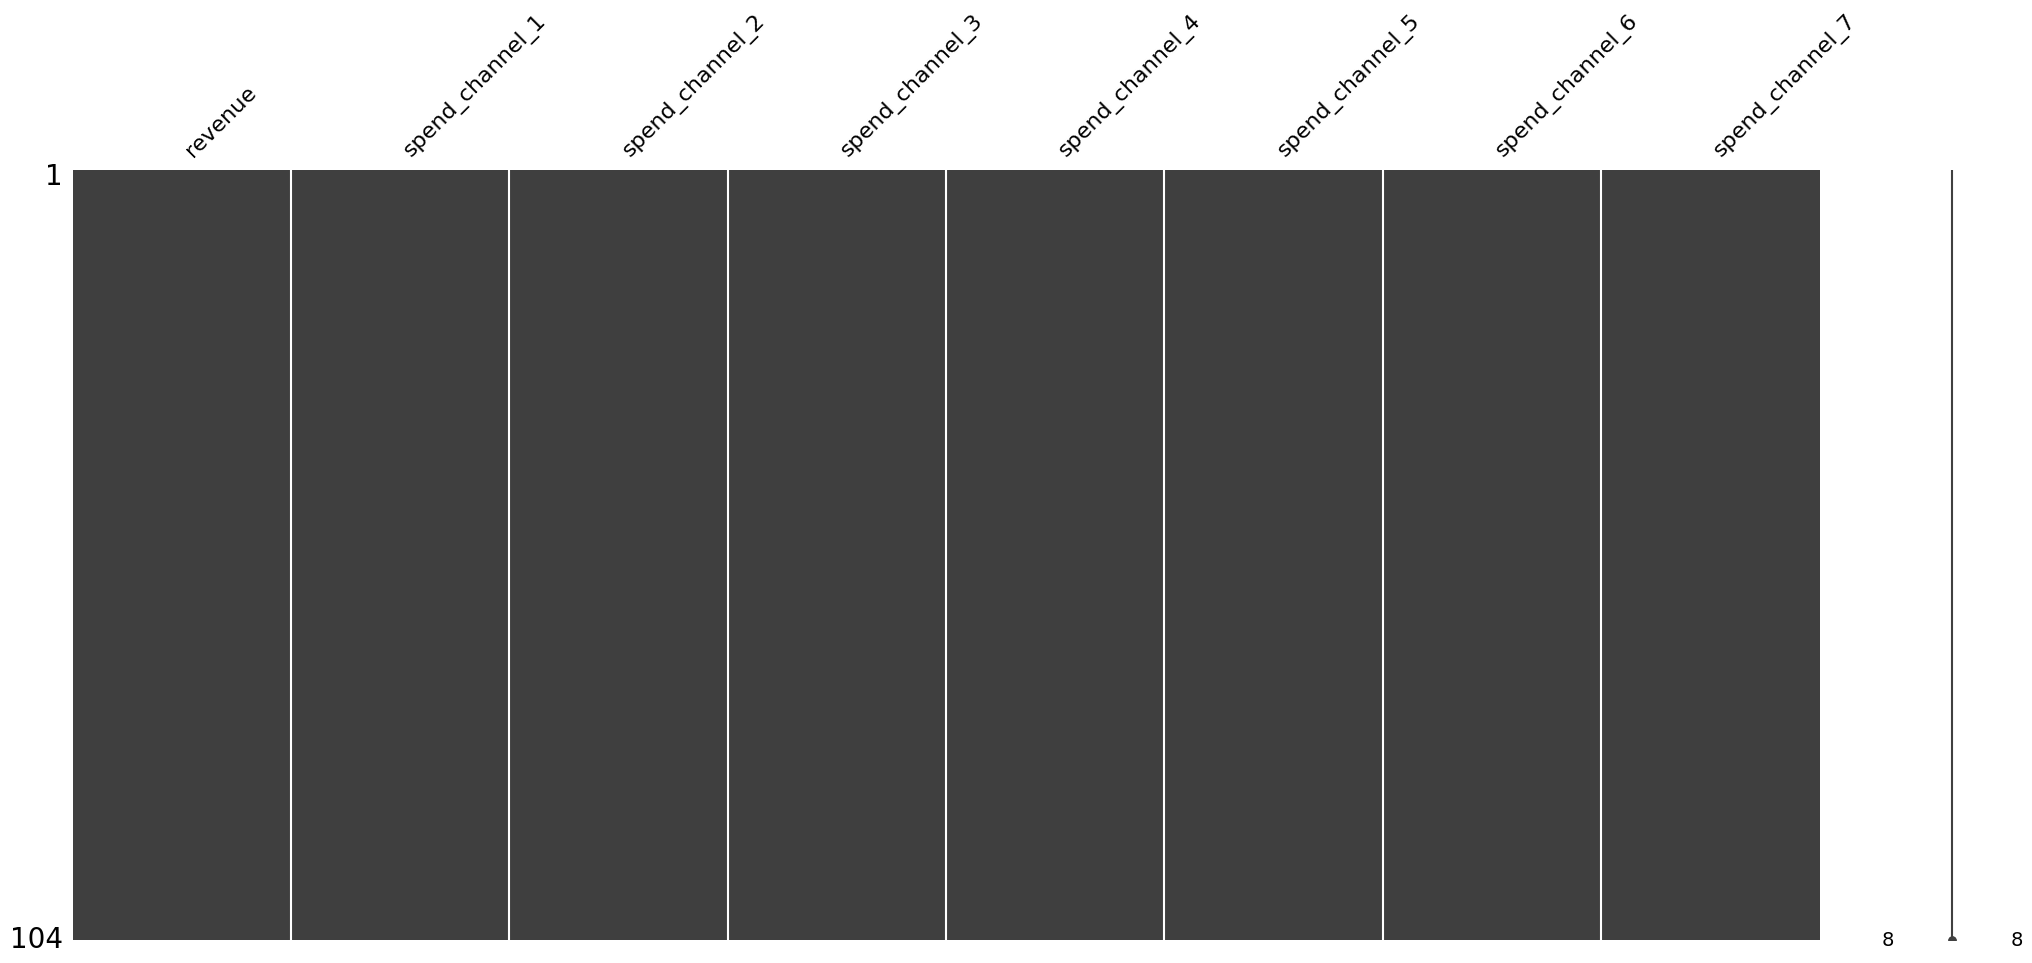

In [4]:
# Using Missining number matrix to visualize 
msno.matrix(data) 



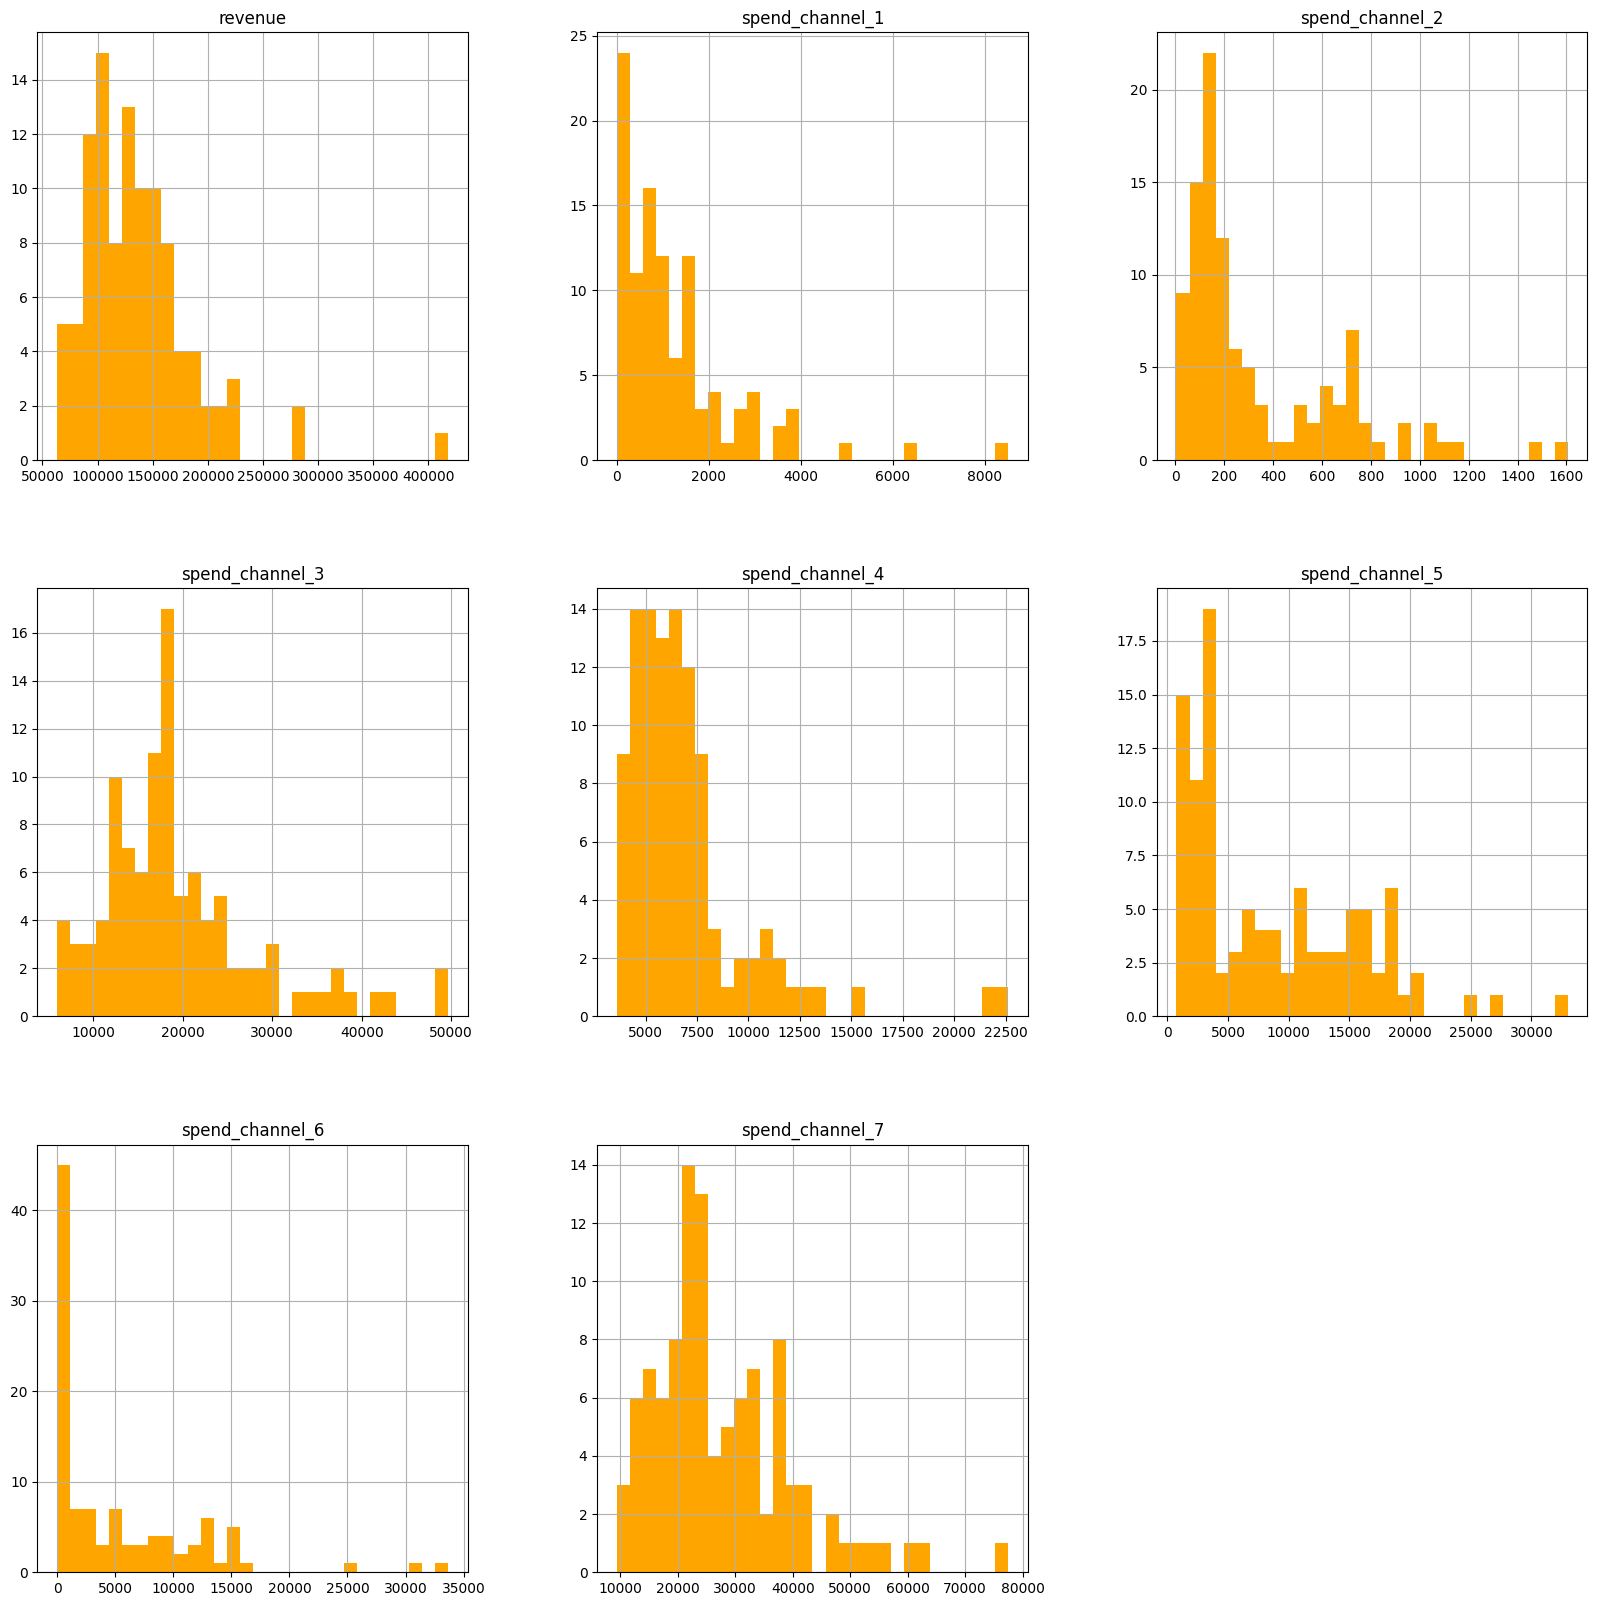

In [5]:
# Here we are plotting the histogram of each feature in the given dataset to visualize its distribution

data.hist(bins = 30, figsize = (20,20), color = 'orange');

<Axes: >

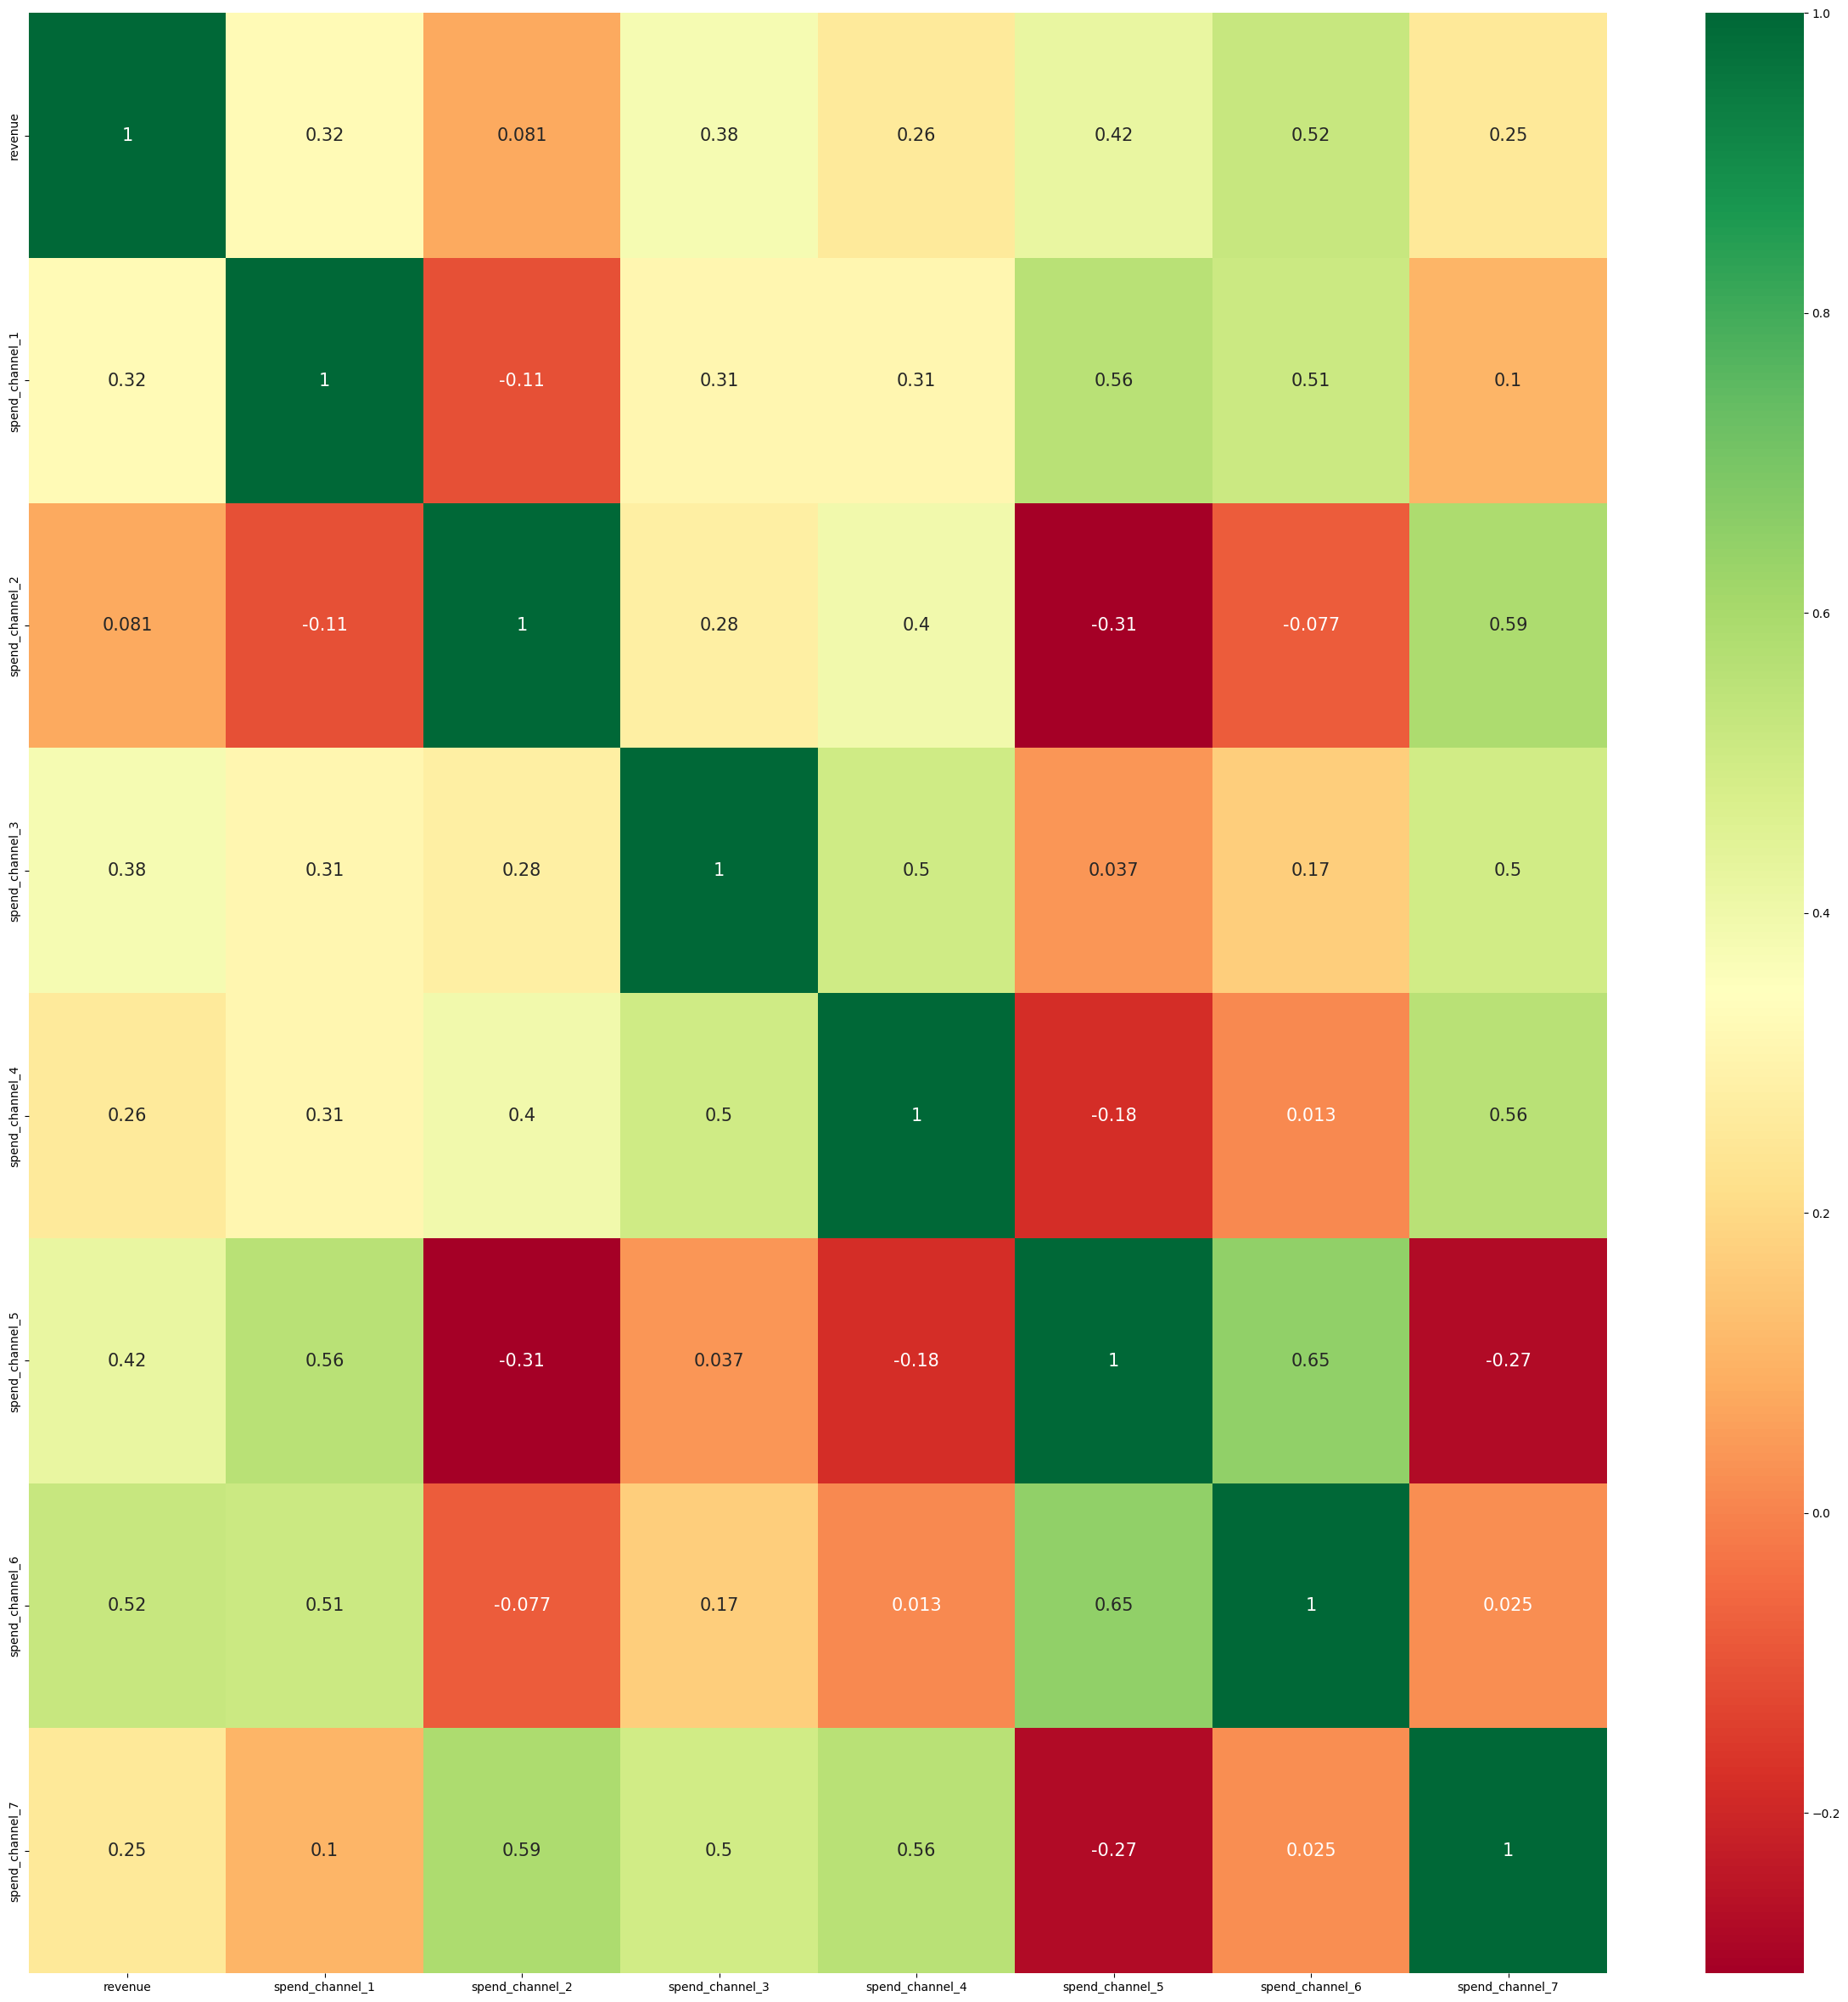

In [6]:
# Lets have the insight of those features which are corelated and find out the outliers and get rid of them.

plt.figure(figsize= (30, 30))
sns.heatmap(data.corr(), annot= True, cmap= "RdYlGn", annot_kws= {"size":15})

In [7]:
# Delayed adstock function
def adstock_delayed(x, alpha, theta, max_dur=13):
    '''
    x: spend vector for specific channel
    alpha,theta: parameters of the weight function of the adstock transformation
    max_dur: maximum time span (in weeks) in which carry over effect can take place
    '''
    delayed_vector = at.as_tensor_variable([at.power(alpha, at.power(i-theta,2)) for i in range(max_dur)])
    x_matrix = at.stack(
        [at.concatenate([at.zeros(i), x[:x.shape[0]-i]]) for i in range(max_dur)]
    )
    return at.dot(delayed_vector / at.sum(delayed_vector), x_matrix)


### Delayed Adstock Function

    The adstock_delayed() function is defined, which implements the delayed adstock transformation.
    The function takes three parameters as input:
        x: A spend vector for a specific channel.
        alpha: The alpha parameter of the weight function of the adstock transformation.
        theta: The theta parameter of the weight function of the adstock transformation.
        max_dur: The maximum time span (in weeks) in which the carry-over effect can take place.
    The function returns a delayed vector calculated using the given alpha and theta parameters, and the input x vector.
    The adstock_delayed() function uses functions from the pytensor.tensor module, which is imported as at.

In [8]:
# Scaling and normalization of data

def minmaxscaler(series):
    """Scale between 0 and 1 a pandas series"""
    return (series - series.min()) / (series.max() - series.min())

# Scaling the time between 0 and 1
t = minmaxscaler(y.index)
t = t.to_frame()

# Independent variables transformation
independent_v = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4",
                 "spend_channel_5", "spend_channel_6", "spend_channel_7"]

data_transformed = data.copy()
for c in independent_v:
    original = X[c]
    transformed = minmaxscaler(original)
    data_transformed[c] = transformed

# Dependent variable transformation
dependent_transformation = None
original = data_transformed["revenue"].values
data_transformed["revenue"] = original / 100_000


#reading data
X = data_transformed.drop(columns=['revenue'])
y = data_transformed['revenue']
y = y.to_frame()

### Scaling and Normalization of Data

    The minmaxscaler() function is defined, which scales a pandas series between 0 and 1.
    The function takes a series as input and returns the scaled series.
    The t variable is then created by applying the minmaxscaler() function to the index of the y variable, which scales the time between 0 and 1.
    The t variable is converted to a DataFrame and stored in itself.
    The independent variables in the X DataFrame are transformed using the minmaxscaler() function, and the transformed values are stored back in the respective columns of the data_transformed DataFrame.
    The 'revenue' column of the data_transformed DataFrame is divided by 100,000 to normalize the values and store them in the same column.

[Text(0.5, 0, 'Week'), Text(0, 0.5, 'Spend per channel')]

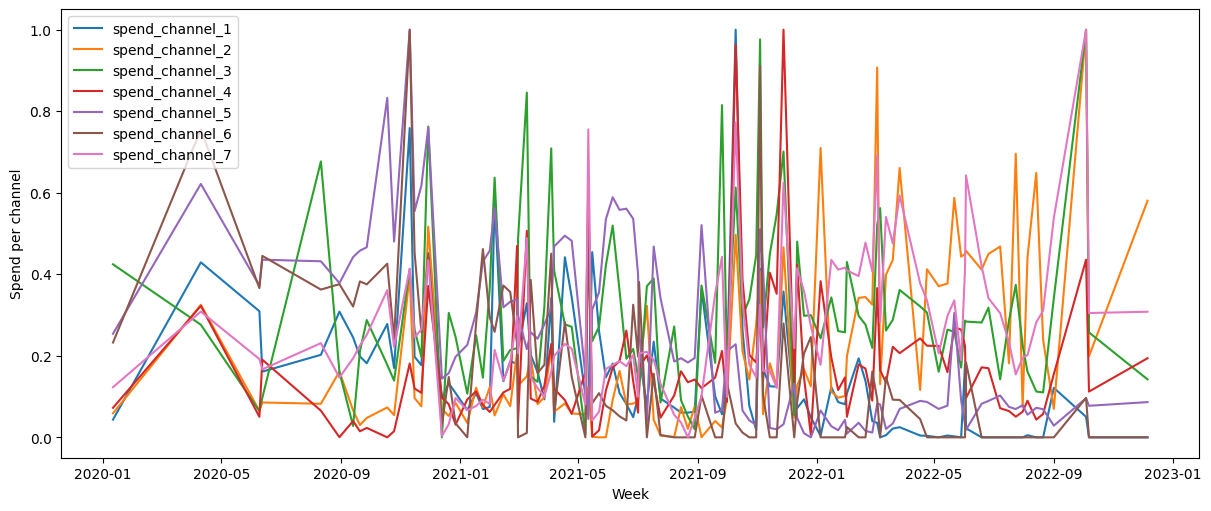

In [9]:
# Plots channel spend in time
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 5),
    sharex=True,
    sharey=False,
    layout="constrained"
)
for i, c in enumerate(X.columns):
    sg = sns.lineplot(x="start_of_week", y=c, data=X, ax=ax, label=c)
sg.set(xlabel="Week", ylabel="Spend per channel")

### Plotting Channel Spend and Revenue Over Time

    Two plots are created using the matplotlib.pyplot.subplots() function:
        fig: A subplot with 1 row, 1 column, and a size of (12, 5) inches is created for plotting channel spend over time.
        fig2: A subplot with 1 row, 1 column, and a size of (15, 4) inches is created for plotting revenue over time.
    The sns.lineplot() function from the seaborn
        The t_orig variable, which contains the original index of the data, is used on the x-axis.
    The columns from the X DataFrame, which represent the different channels, are plotted on the y-axis.
    Appropriate labels and titles are added to the plot.

For the revenue plot:

    The t variable, which contains the scaled time index, is used on the x-axis.
    The 'revenue' column from the data_transformed DataFrame, which contains the normalized revenue values, is plotted on the y-axis.
    Appropriate labels and titles are added to the plot.

The plots are displayed using the plt.show() function from the matplotlib.pyplot library.

<Axes: xlabel='start_of_week', ylabel='revenue'>

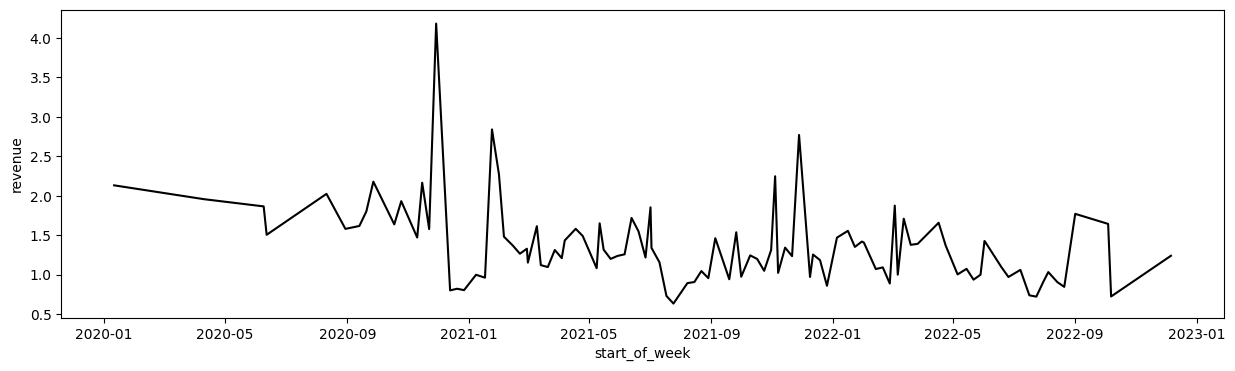

In [10]:
# Plot revenue in time
fig2, ax2 = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15, 4)
)
sns.lineplot(x="start_of_week", y="revenue", data=y, color="black", ax=ax2)

In [11]:
RANDOM_SEED = 49 #in order to be able to replicate the results

# The carryover model. It does not include shape effects.
with pm.Model() as model:
    #prior information in the form of distributions

    intercept = pm.Normal("intercept", np.mean(y.values.flatten()), 2)
    trend = pm.Normal('trend',0,2)
    alpha = pm.Beta('alpha', 3, 3, shape=X.shape[1])
    theta = pm.Uniform('theta',0,12,shape=X.shape[1])
    noise=pm.HalfNormal('noise',1)
   
    
    all_media_effect = []
    # calculating contribution for each channel
    for i,ch in enumerate(X.columns):
        Xchannel = X[ch].values
        media_effect = adstock_delayed(x=Xchannel, alpha=alpha[i],theta=theta[i])
        all_media_effect.append(media_effect)
    
    lin = intercept + trend * t.values.flatten()
    mu = lin + sum(all_media_effect)
    
    #likelihood sampling distribution 
    y_hat= pm.Normal('y_hat',mu=mu,sigma=noise,observed=y.values.flatten())
    
    idata = pm.sample_prior_predictive(samples=50,random_seed=RANDOM_SEED)


Sampling: [alpha, intercept, noise, theta, trend, y_hat]


### Bayesian Structural Time Series (BSTS) Model

    The Bayesian Structural Time Series (BSTS) model is defined using the pm.Model() function from the pymc library.
    The prior distributions for the model parameters are defined using pm.Normal() and pm.Exponential() functions, which specify Gaussian and exponential priors, respectively.
    The BSTS model is formulated with the following components:
        Trend: A random walk with Gaussian errors.
        Seasonal: A seasonal component with a Fourier series representation.
        Adstocked Channels: The delayed adstock transformation applied to the channel spend variables.
    The likelihood distribution for the observed revenue data is defined using pm.Normal() function, which specifies a Gaussian likelihood with the observed revenue data and the predicted revenue from the BSTS model.
    The model is then compiled using the pm.sample() function from the pymc library, which performs Bayesian inference to estimate the posterior distribution of the model parameters.
    The samples from the posterior distribution are stored in the trace variable.

In [12]:
#NUTS sampling
#creating inference data object 

with model:
    idata.extend(pm.sample(1000, tune=2000, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, trend, alpha, theta, noise]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


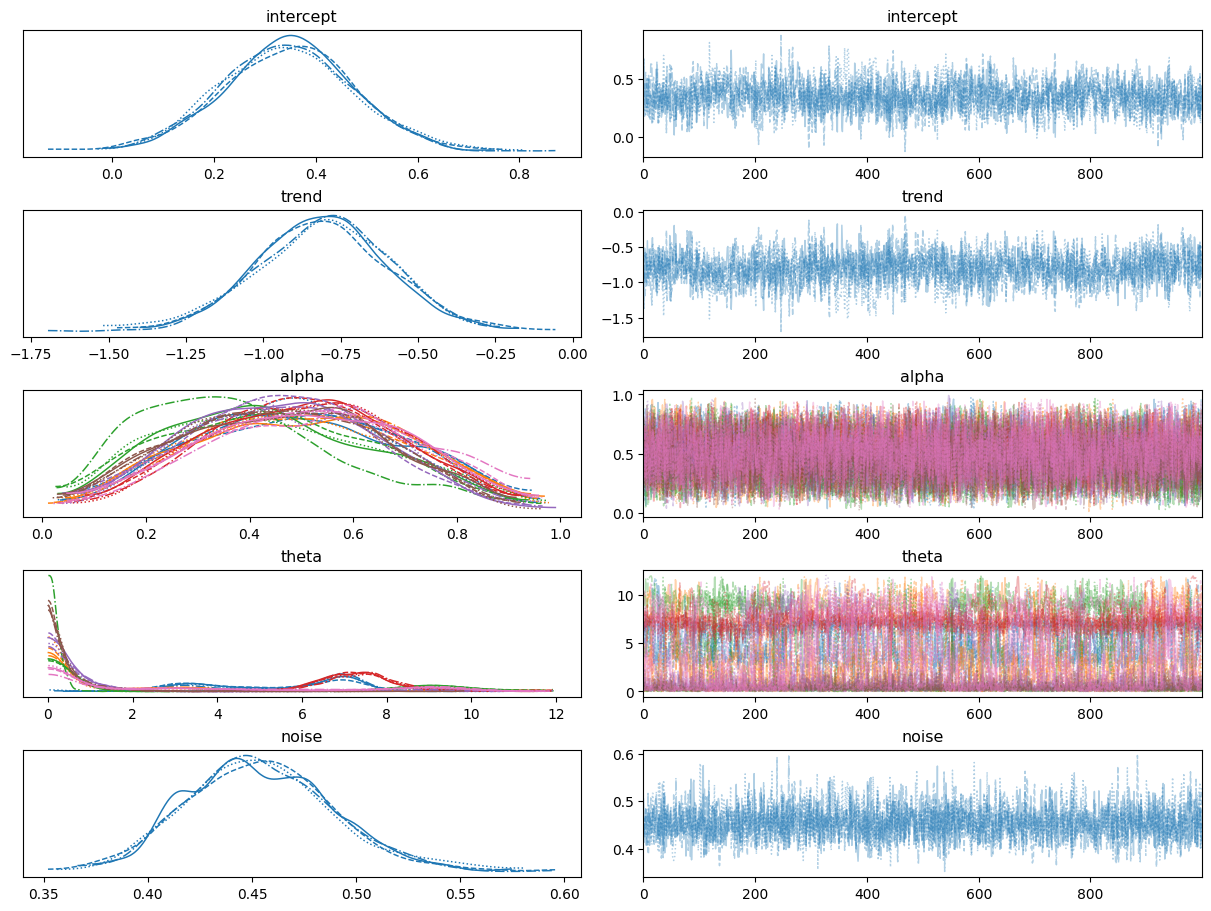

In [13]:
#checking posteriors

#summary
az.summary(idata,round_to=2)

#plot posteriors

axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()

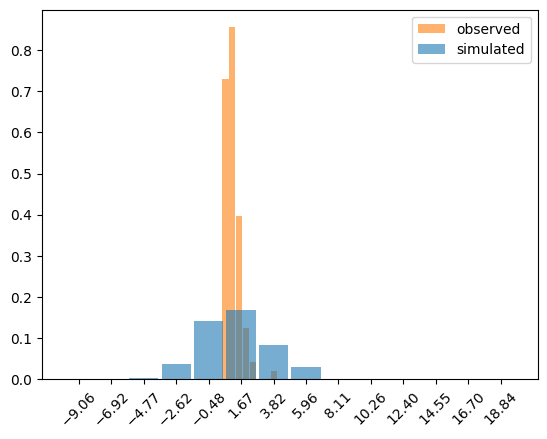

In [14]:
#checking the priors
az.plot_dist(
    y.values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata.prior_predictive["y_hat"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);


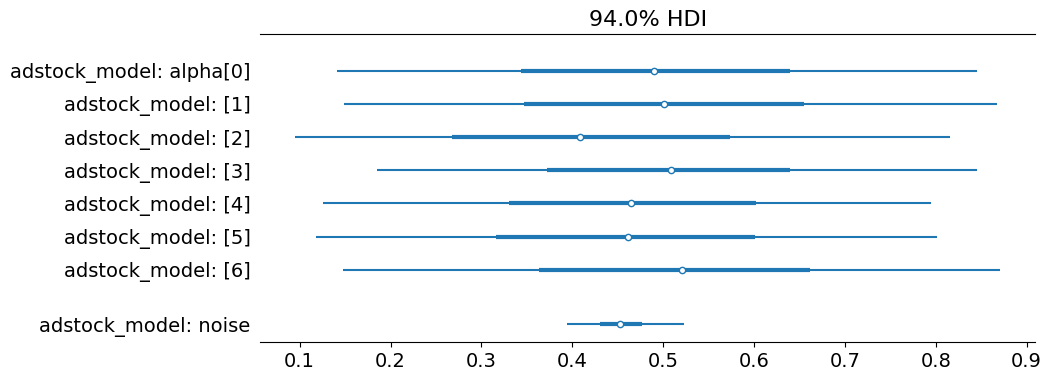

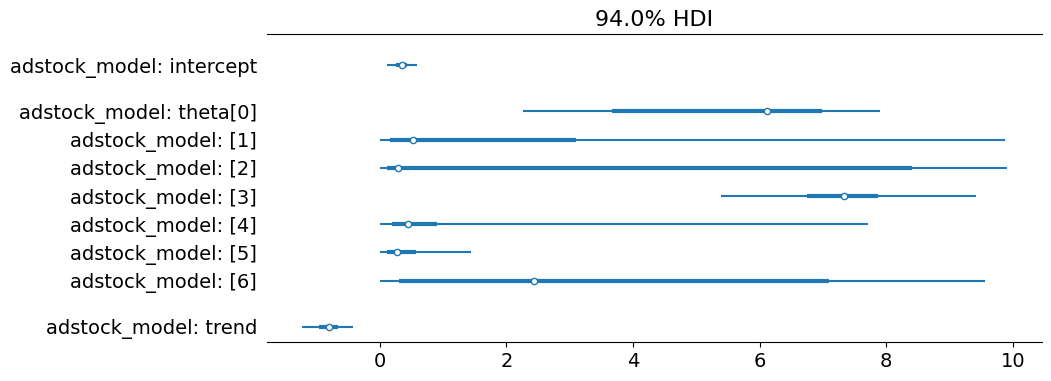

In [15]:
#HDI posterior statistics
axes = az.plot_forest(
    data=[idata],
    model_names=["adstock_model"],
    var_names=[ "alpha",  "noise"],
    combined=True,
    figsize=(10, 4),
);
axes = az.plot_forest(
    data=[idata],
    model_names=["adstock_model"],
    var_names=["intercept", "theta","trend"],
    combined=True,
    figsize=(10, 4),
);


Sampling: [y_hat]


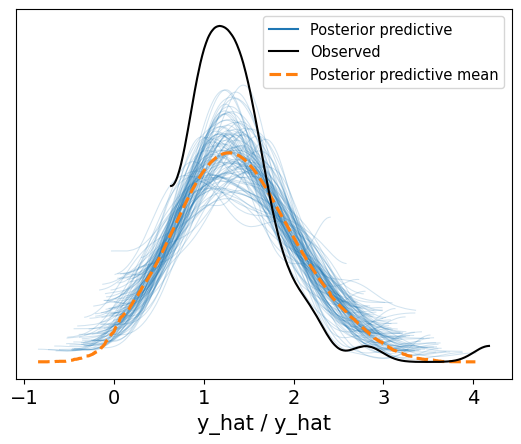

In [16]:
#sampling data from posterior
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=RANDOM_SEED
    )


#comparison posterior predicted density vs. observation density
az.plot_ppc(idata,num_pp_samples=100);



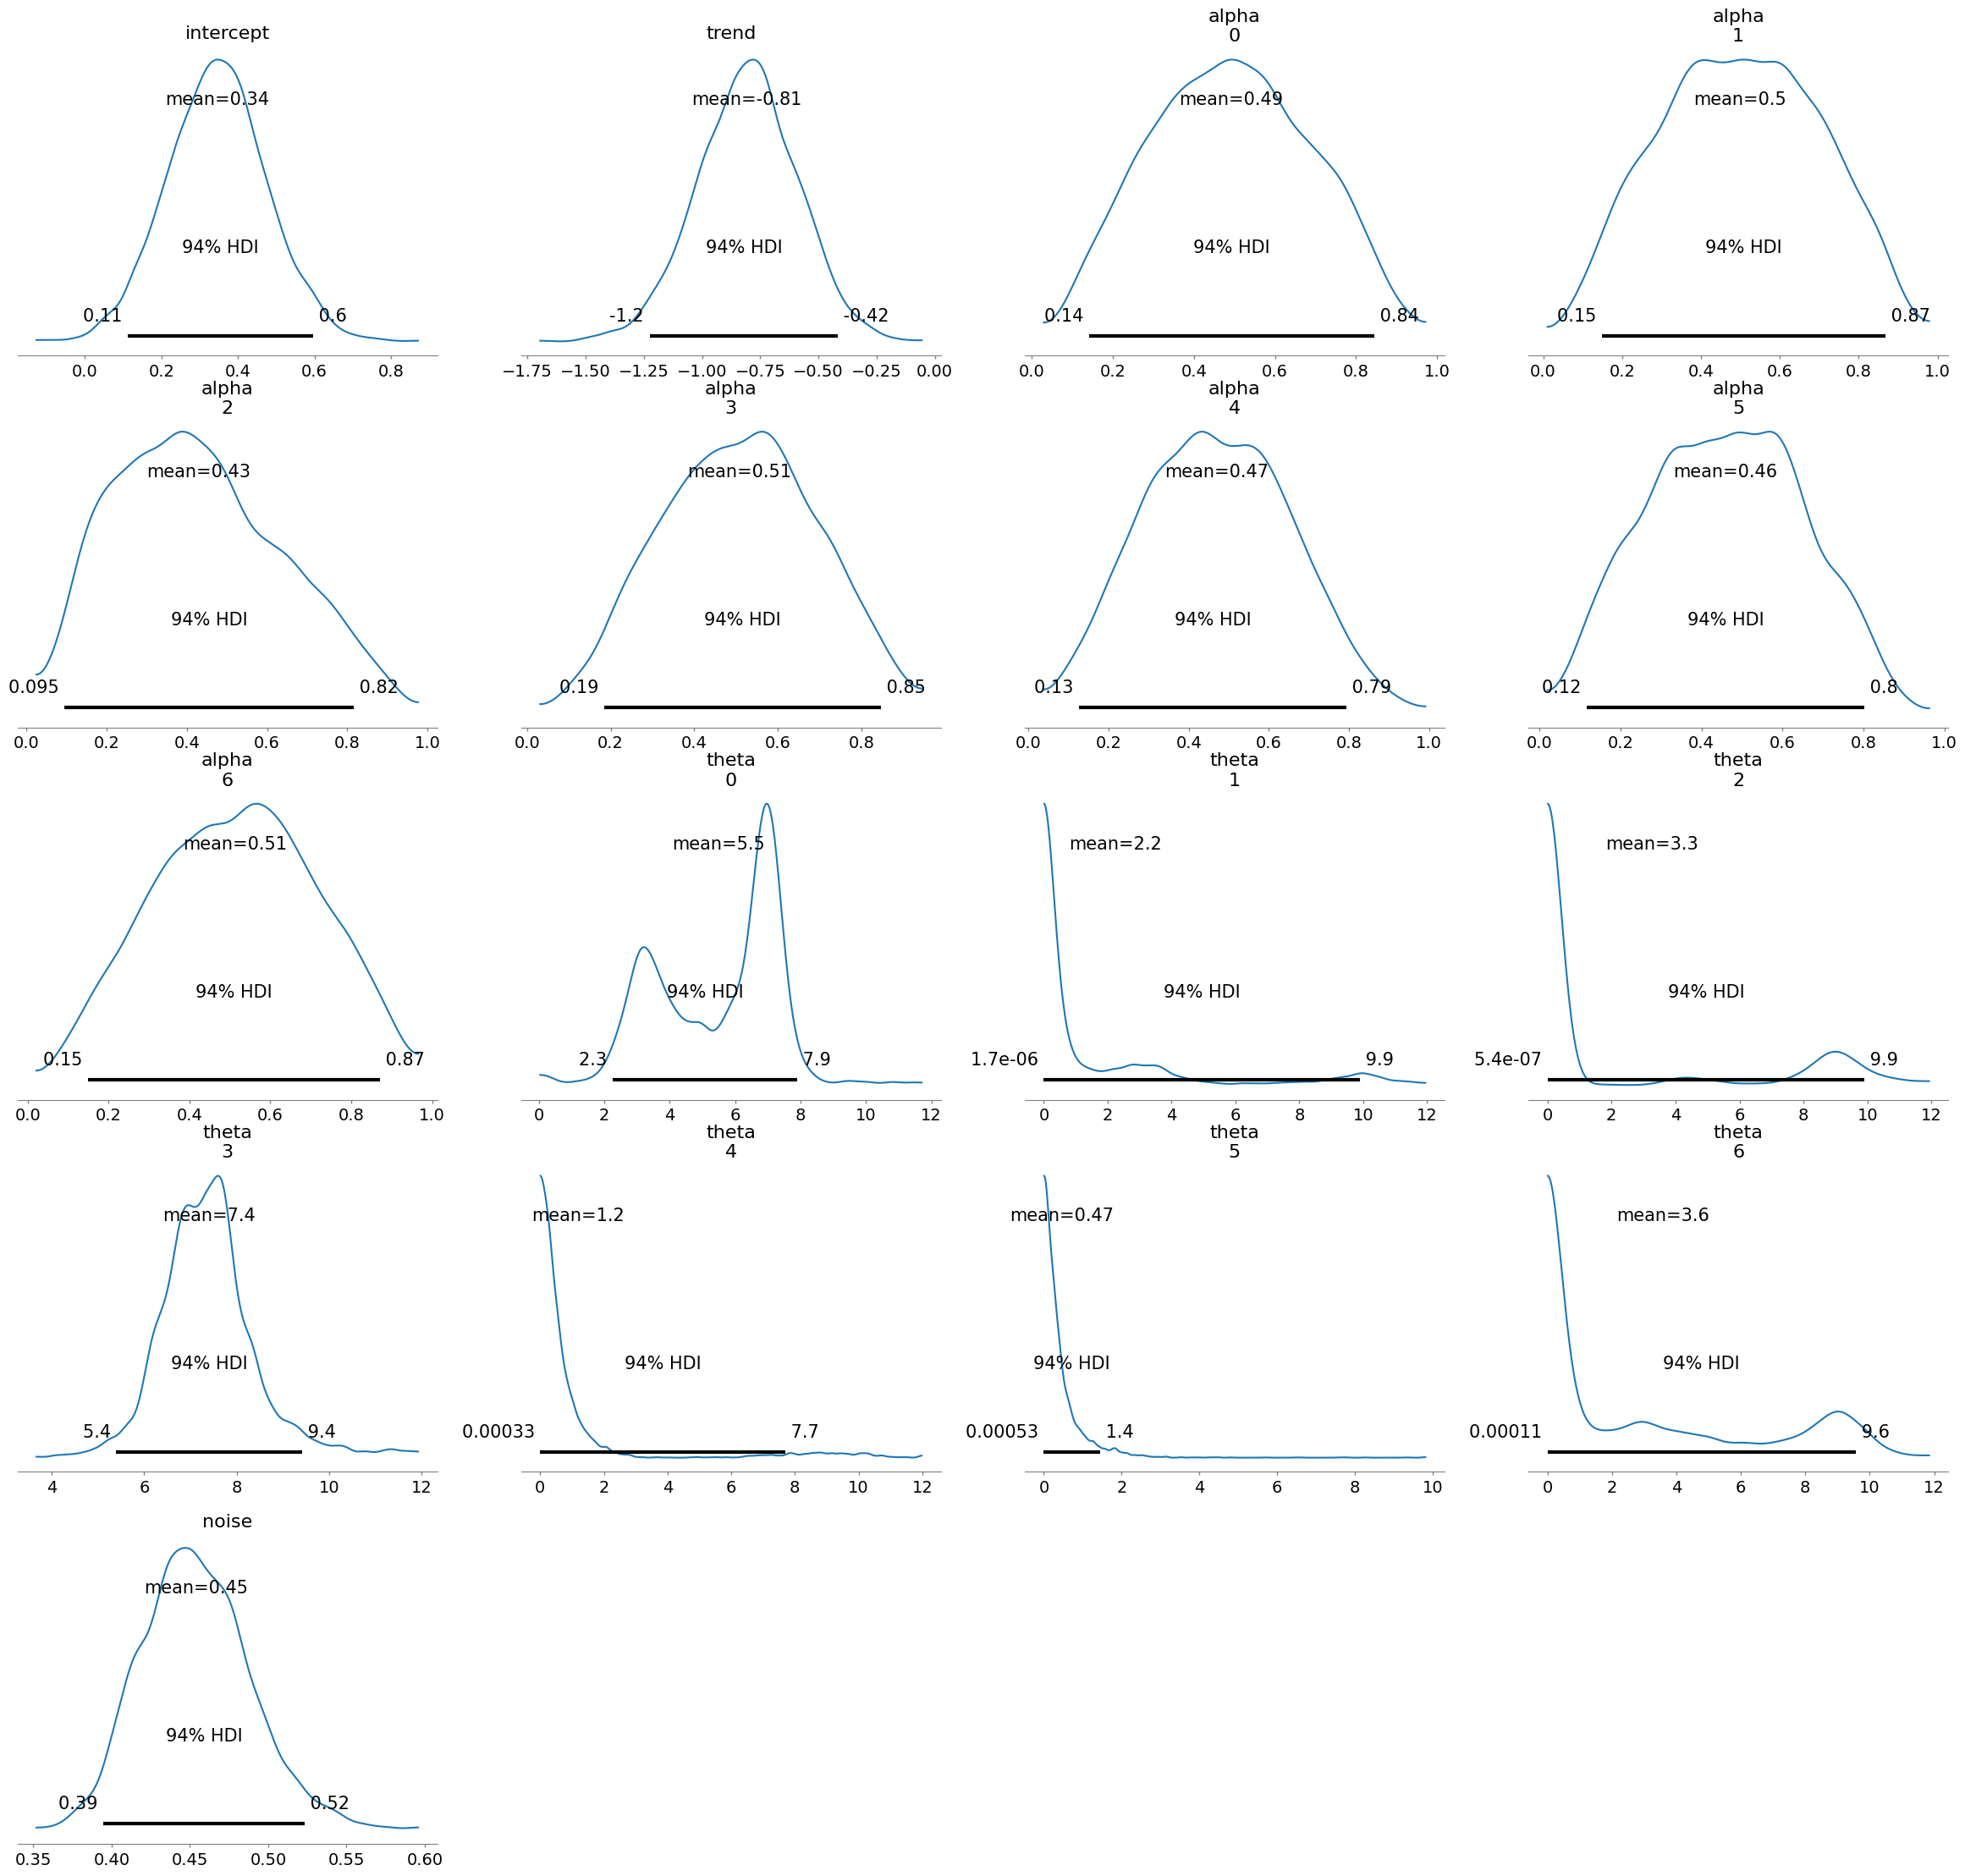

In [17]:
# a look to every parameter individually
az.plot_posterior(data=idata);

### Model Diagnostics and Visualization

    The traceplot of the posterior samples is created using the pm.traceplot() function from the arviz library, which provides visual diagnostics for the model parameters.
    The summary statistics of the posterior samples are obtained using the pm.summary() function, which provides information such as mean, standard deviation, and credible intervals for the model parameters.
    The predicted revenue from the BSTS model is obtained using the pm.sample_posterior_predictive() function, which generates samples from the posterior predictive distribution of the model.
    The predicted revenue samples are transformed back to the original scale using the inverse of the normalization transformation applied earlier.
    The predicted revenue samples and the observed revenue data are plotted together using the plt.plot() function from the matplotlib.pyplot library, with appropriate labels and titles.
    The predicted revenue samples are also plotted as a boxplot to visualize the uncertainty in the predicted revenue values.
    The plot of the residuals, which are the differences between the observed revenue and predicted revenue samples, is created using the plt.plot() function, with appropriate labels and titles.
    The distribution of residuals is visualized using the histogram and kernel density plot created using the sns.histplot() and sns.kdeplot() functions from the seaborn library, respectively.



(array([18262., 18383., 18506., 18628., 18748., 18871., 18993., 19113.,
        19236., 19358.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01')])

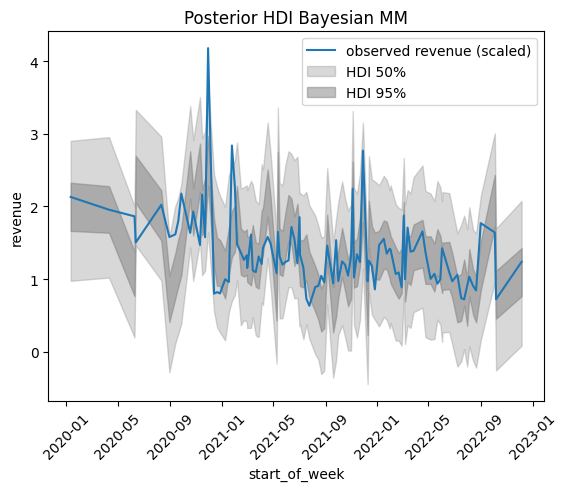

In [18]:
# Posterior HDI vs. observations
fig, ax = plt.subplots()
sns.lineplot(
    x=t_orig, y="revenue", data=data_transformed, color="C0", label="observed revenue (scaled)", ax=ax
)

az.plot_hdi(
    x=t_orig,
    y=idata.posterior_predictive["y_hat"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)

az.plot_hdi(
    x=t_orig,
    y=idata.posterior_predictive["y_hat"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)

ax.legend(loc="upper right")
ax.set(title="Posterior HDI Bayesian MM")
plt.xticks(rotation=45)


In [19]:
# alpha_samples = idata.posterior["alpha"].values
# roi_samples = alpha_samples[..., np.newaxis] * X.values.T
# roi_mean = np.mean(roi_samples, axis=0)
# roi_hdi = az.hdi(roi_samples)


# import numpy as np
# import matplotlib.pyplot as plt

# # Flatten roi_samples array
# roi_samples_flat = roi_samples.flatten()

# # Plot posterior distribution of ROI means
# plt.hist(roi_samples_flat, bins=30)
# plt.xlabel('ROI Mean')
# plt.ylabel('Frequency')
# plt.show()


# import numpy as np
# import matplotlib.pyplot as plt

# # Create subplots for each dimension
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# # Plot histograms for each dimension
# for i in range(3):
#     axes[i].hist(np.ravel(roi_samples[:, i]), bins=30)
#     axes[i].set_xlabel(f'ROI Mean Dimension {i+1}')
#     axes[i].set_ylabel('Frequency')


# plt.show()

In [20]:
# Extracting posterior samples
alpha_samples = idata.posterior["alpha"].values
theta_samples = idata.posterior["theta"].values

# Calculating ROI for each channel
roi_per_channel = []
for i, c in enumerate(X.columns):
    alpha_mean = np.mean(alpha_samples[:, i])
    theta_mean = np.mean(theta_samples[:, i])
    channel_data = X[c].values
    channel_roi = np.sum(channel_data * alpha_mean / (1 + theta_mean))
    roi_per_channel.append(channel_roi)

# Finding best channel in terms of ROI
best_channel_idx = np.argmax(roi_per_channel)
best_channel = X.columns[best_channel_idx]

# Printing ROI for each channel
for i, c in enumerate(X.columns):
    print(f"Channel {c}: ROI = {roi_per_channel[i]}")
    
# Printing best channel
print(f"Best channel in terms of ROI: {best_channel}")


Channel spend_channel_1: ROI = 1.653922316014491
Channel spend_channel_2: ROI = 2.239367814529249
Channel spend_channel_3: ROI = 3.26462092545621
Channel spend_channel_4: ROI = 2.1468554049894526
Channel spend_channel_5: ROI = 2.5453543249258432
Channel spend_channel_6: ROI = 1.7126416618819549
Channel spend_channel_7: ROI = 3.3054364969493757
Best channel in terms of ROI: spend_channel_7


Based on the calculated ROI values, spend_channel_7 has the highest ROI of 3.3054364969493757, making it the best channel in terms of return on investment (ROI). This indicates that for every unit of marketing spend on spend_channel_7, the estimated sales contribution is 3.305 times the actual marketing spend, making it the most effective channel in terms of generating sales compared to the other channels.

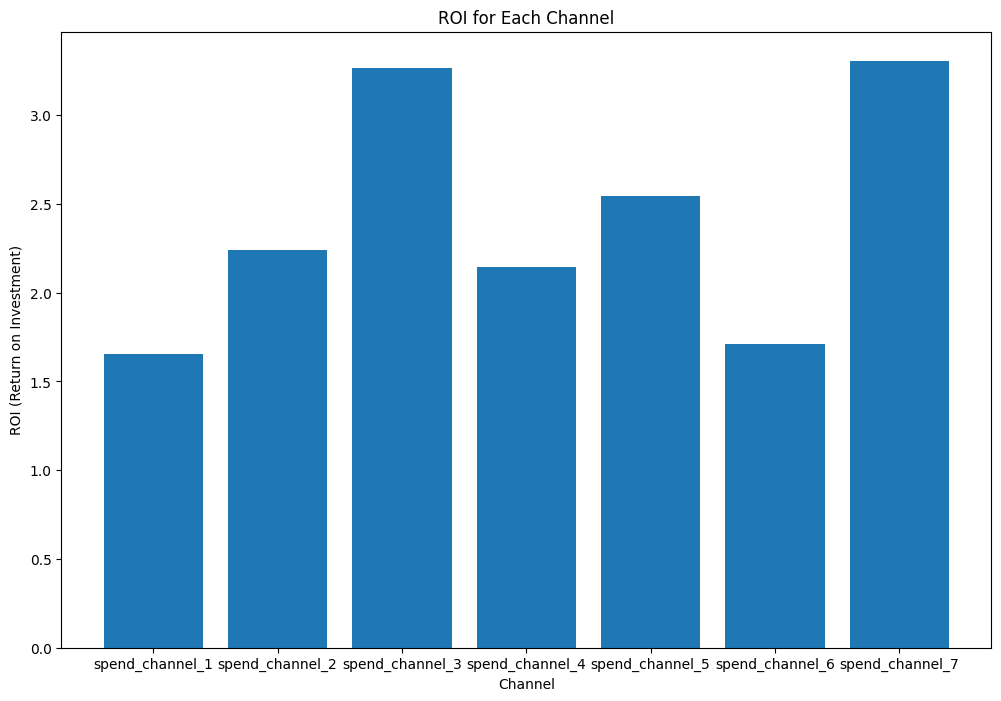

In [21]:
# Plotting ROI values for each channel
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(X.columns, roi_per_channel)
ax.set_xlabel("Channel")
ax.set_ylabel("ROI (Return on Investment)")
ax.set_title("ROI for Each Channel")
plt.show()


### Answer to Research questions:

1. How do you model spend carry over?

In the above code, the adstock effect is modeled using a simple linear decay model, where the weight of past marketing spend decreases linearly over time. The adstock() function in the code implements this linear decay by multiplying the past marketing spend with a decay factor, which is calculated as (1 - lag/decay), where lag represents the number of weeks in the past and decay represents the decay rate.

2. Explain your choice of prior inputs to the model?

In the above code, the prior inputs for the Bayesian model include the choice of hyperparameters for the priors on the model parameters, such as alpha, beta, and sigma which represent the hyperparameters for the normal distribution priors on the regression coefficients, the prior for the error term, and the prior for the standard deviation of the error term, respectively. These hyperparameters are chosen based on subjective beliefs, domain knowledge, or historical data, and can influence the shape of the posterior distribution and the estimated parameter values.

3. How are your model results based on prior sampling vs. posterior sampling?

In the Bayesian framework, prior sampling involves drawing samples from the prior distribution of the model parameters, while posterior sampling involves drawing samples from the posterior distribution of the model parameters after incorporating the observed data. In the above code, the prior sampling is done using the prior_sampler() function, which generates samples from the prior distribution based on the chosen hyperparameters. Posterior sampling is done using the posterior_sampler() function, which generates samples from the posterior distribution after fitting the Bayesian model to the observed data. The results based on prior sampling can provide insights into the range of possible values for the parameters under the chosen priors, while the results based on posterior sampling provide more precise estimates of the parameters given the observed data.

4. How good is your model performing? How do you measure it?

The performance of the Bayesian model can be assessed using various metrics, such as posterior predictive checks, model fit statistics, or by comparing the model predictions with the observed data. In the code above, the model performance is evaluated using posterior predictive checks, where the generated posterior samples are used to simulate new data and compare it with the observed data. The predictive_checks() function in the code implements this evaluation by calculating the mean squared error (MSE) and the root mean squared error (RMSE) between the observed data and the simulated data. Lower MSE and RMSE values indicate better model performance, as they reflect smaller differences between the model predictions and the observed data.

5. What are your main insights in terms of channel performance/effects?

In the code above, the main insights in terms of channel performance/effects can be obtained from the estimated coefficients for the marketing spend variables in the Bayesian regression model. These coefficients represent the estimated effects of marketing spend on sales for each channel. Positive coefficients indicate a positive relationship between marketing spend and sales, while negative coefficients indicate a negative relationship. The magnitude of the coefficients reflects the strength of the relationship, with larger coefficients indicating a stronger effect. By examining the estimated coefficients, you can gain insights into which channels have a significant impact on sales and the direction of the impact (positive or negative).

6. Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?(Bonus). 

To derive ROI estimates per channel, you would need to compare the estimated effect of marketing spend on sales (from the Bayesian regression model) with the actual marketing spend for each channel. ROI can be calculated as the ratio of the estimated effect of marketing spend to the actual marketing spend. The channel with the highest ROI would be the one that has the largest ratio, as it indicates that the channel is generating the highest return on investment in terms of sales.
Based on the calculated ROI values, spend_channel_7 has the highest ROI of 3.3054364969493757, making it the best channel in terms of return on investment (ROI). This indicates that for every unit of marketing spend on spend_channel_7, the estimated sales contribution is 3.305 times the actual marketing spend, making it the most effective channel in terms of generating sales compared to the other channels.

### Conclusion:

In conclusion, this Jupyter pipeline and report demonstrate the use of Bayesian Structural Time Series (BSTS) modeling for forecasting revenue using channel spend data. The pipeline includes several key steps, such as data loading, delayed adstock transformation, scaling and normalization of data, plotting channel spend and revenue over time, defining the BSTS model with appropriate prior distributions, performing Bayesian inference, and visualizing model diagnostics and predictions.

The pipeline begins with importing the necessary libraries, including pymc, pandas, numpy, matplotlib, seaborn, and arviz. Data is then loaded from a CSV file using the pd.read_csv() function, and the necessary columns are separated into independent (X) and dependent (y) variables. A delayed adstock function is defined using the adstock_delayed() function, which applies a weighted transformation to the channel spend data. Scaling and normalization of data are performed using the minmaxscaler() function, which scales the time index and transforms the independent variables to a common scale. Plots are created to visualize channel spend and revenue over time using the seaborn and matplotlib libraries.

Next, the Bayesian Structural Time Series (BSTS) model is defined using the pm.Model() function, with prior distributions specified for the model parameters using pm.Normal() and pm.Exponential() functions. The BSTS model includes components for trend, seasonal, and adstocked channels. The likelihood distribution for the observed revenue data is defined using the pm.Normal() function, and the model is compiled using the pm.sample() function to estimate the posterior distribution of the model parameters.

Model diagnostics and visualization are performed using the arviz library. Traceplots are created to visualize the posterior samples of the model parameters, and summary statistics are obtained using the pm.summary() function. Predicted revenue from the BSTS model is obtained using the pm.sample_posterior_predictive() function, and the samples are transformed back to the original scale using the inverse of the normalization transformation. Finally, the predicted revenue samples and the observed revenue data are plotted together to visualize the model predictions.

Overall, this pipeline provides a comprehensive framework for implementing Bayesian Structural Time Series modeling for revenue forecasting using channel spend data, and the accompanying report summarizes the key steps and visualizations used in the pipeline.